In [15]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
from pprint import pprint
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('data.csv')
print(len(df), 'fights')
print(len(df.columns), 'features')

1477 fights
895 features


In [91]:
fight_features = set()
fighter_features = set()
general_features = set()

for c in df.columns:
    if (c[1:8] == '__Round'):
        fight_features.add(c[9:])
    elif c[0] == 'B' or c[0] == 'R':
        fighter_features.add(c[1:])
    else:
        general_features.add(c)
print(len(fight_features)) # features of each round
print(len(fighter_features)) # features of each fighter
print(len(general_features)) # features of each fight

87
9
7


In [119]:
team_map = {'red': 'R', 'blue': 'B'}

def collapse_fighter(fighter_dict, team, row):
    assert(type(fighter_dict) == dict)
    assert(team == 'R' or team == 'B')
    name = row[team+'_Name']
    n = fighter_dict.get(name, dict())
    n['count_'] = n.get('count_', 0) + 1
    n['Id'] = n.get(id, row['{}_ID'.format(team)])
    tmp = dict()
    rounds = row['Max_round']
    for round_ in range(1, rounds+1):
        for f in fight_features:
            tmp[f] = tmp.get(f, 0.) + row['{}__Round{}{}'.format(team, round_, f)]
            #print(f, row["{}__Round{}{}".format(team, round_, f)])
    n['Streak'] = (n.get('Streak', 0) + row['{}Streak'.format(team)])
    if team_map.get(row['winner'], "") == team:
        n['wins'] = n.get('wins', 0) + 1
    for f in fight_features:
        tmp[f] = tmp[f]/rounds
        n[f] = n.get(f, 0) + tmp[f]
    fighter_dict[name] = n

In [120]:
ndf = df
ndf = ndf.fillna(0)
fighters = dict()

for idx, row in ndf.iterrows():
    collapse_fighter(fighters, 'R', row)
    collapse_fighter(fighters, 'B', row)

In [121]:
print(len(fighters))
for fighter in fighters:
    fd = fighters[fighter]
    count = fd['count_']
    fd['Id'] = int(fd['Id'])
    for f in fight_features:
        fd[f] = fd[f]/count
    fd['Streak'] = fd['Streak']/count
    fd['wins'] = fd.get('wins', 0)
    fd['win_prob'] = fd['wins']/count
    fighters[fighter] = fd        

852


In [122]:
fighterdf = pd.DataFrame(fighters).T
fighterdf.head()

,Id,Streak,_Grappling_Reversals_Landed,_Grappling_Standups_Landed,_Grappling_Submissions_Attempts,_Grappling_Takedowns_Attempts,_Grappling_Takedowns_Landed,_Strikes_Body Significant Strikes_Attempts,_Strikes_Body Significant Strikes_Landed,_Strikes_Body Total Strikes_Attempts,...,_TIP_Guard Control Time,_TIP_Half Guard Control Time,_TIP_Misc. Ground Control Time,_TIP_Mount Control Time,_TIP_Neutral Time,_TIP_Side Control Time,_TIP_Standing Time,count_,win_prob,wins
Aaron Phillips,2237.0,0.000000,0.0,0.500000,0.166667,0.000000,0.000000,2.333333,2.000000,4.666667,...,0.000000,6.833333,2.833333,0.000000,34.833333,0.833333,45.333333,2.0,0.000000,0.0
Abdul Razak Alhassan,2634.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,1.0
Abel Trujillo,2013.0,1.166667,0.0,0.222222,0.111111,2.333333,0.611111,2.111111,1.055556,2.944444,...,16.166667,0.000000,13.111111,3.277778,189.333333,0.000000,225.222222,6.0,0.666667,4.0
Abner Lloveras,2730.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.0
Adam Milstead,2763.0,0.500000,0.0,0.000000,0.000000,0.000000,0.000000,1.333333,0.833333,1.333333,...,0.000000,0.000000,0.000000,0.000000,59.000000,0.000000,90.000000,2.0,0.500000,1.0


In [131]:
fighterdf.sort_values('wins', ascending=False)

,Id,Streak,_Grappling_Reversals_Landed,_Grappling_Standups_Landed,_Grappling_Submissions_Attempts,_Grappling_Takedowns_Attempts,_Grappling_Takedowns_Landed,_Strikes_Body Significant Strikes_Attempts,_Strikes_Body Significant Strikes_Landed,_Strikes_Body Total Strikes_Attempts,...,_TIP_Guard Control Time,_TIP_Half Guard Control Time,_TIP_Misc. Ground Control Time,_TIP_Mount Control Time,_TIP_Neutral Time,_TIP_Side Control Time,_TIP_Standing Time,count_,win_prob,wins
Donald Cerrone,1076.0,2.923077,0.000000,0.235897,1.102564,3.400000,0.928205,27.953846,18.235897,30.261538,...,8.646154,29.810256,2.784615,25.605128,785.205128,2.738462,825.851282,13.0,0.846154,11.0
Max Holloway,1936.0,4.500000,0.000000,0.480000,0.600000,0.433333,0.193333,25.846667,20.646667,28.260000,...,2.333333,8.160000,46.526667,22.960000,545.553333,0.180000,631.000000,10.0,1.000000,10.0
Neil Magny,2047.0,2.583333,0.000000,2.816667,0.155556,9.361111,4.127778,18.855556,13.161111,34.688889,...,0.211111,48.788889,11.311111,73.911111,630.688889,3.333333,869.911111,12.0,0.833333,10.0
Beneil Dariush,2168.0,1.727273,0.000000,0.272727,1.060606,4.545455,1.696970,20.090909,12.787879,25.545455,...,35.030303,56.666667,4.848485,59.606061,408.212121,8.818182,524.818182,11.0,0.727273,8.0
Derrick Lewis,2082.0,1.400000,0.000000,1.620000,0.000000,1.553333,0.606667,2.993333,2.633333,3.446667,...,7.800000,28.840000,20.693333,38.700000,118.286667,5.540000,199.373333,10.0,0.800000,8.0
Tony Ferguson,1815.0,3.500000,0.108333,1.083333,1.358333,1.133333,0.616667,8.500000,5.100000,10.516667,...,0.000000,0.733333,30.683333,21.283333,297.533333,4.075000,323.025000,8.0,1.000000,8.0
Francisco Trinaldo,1997.0,2.900000,0.000000,1.166667,0.266667,2.933333,1.166667,19.700000,15.500000,28.566667,...,113.566667,6.533333,0.000000,21.700000,686.833333,2.433333,816.433333,10.0,0.800000,8.0
Gegard Mousasi,786.0,1.272727,0.054545,0.230303,0.636364,1.606061,1.109091,6.884848,5.872727,14.757576,...,61.515152,70.618182,0.000000,48.648485,493.018182,26.830303,552.442424,11.0,0.727273,8.0
Kelvin Gastelum,2070.0,1.111111,0.044444,0.814815,0.192593,1.429630,0.696296,14.762963,9.814815,18.444444,...,27.740741,3.200000,14.355556,23.874074,616.614815,2.622222,719.459259,9.0,0.777778,7.0
Jorge Masvidal,1272.0,1.000000,0.000000,1.366667,0.706667,2.713333,1.400000,23.773333,19.800000,31.520000,...,65.253333,26.033333,66.166667,8.253333,1185.860000,0.000000,940.966667,10.0,0.700000,7.0


Index(['wins', 'count_', 'Streak', '_Strikes_Significant Strikes_Landed',
       '_Strikes_Head Significant Strikes_Landed',
       '_Strikes_Total Strikes_Landed', '_Strikes_Head Total Strikes_Landed',
       '_Strikes_Total Strikes_Attempts',
       '_Strikes_Head Total Strikes_Attempts', '_TIP_Standing Time'],
      dtype='object')


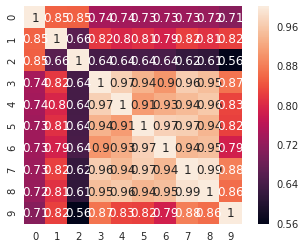

In [130]:
#
import seaborn as sns
k = 10
corrmat = fighterdf.corr()
cols = corrmat.nlargest(k, 'wins')['wins'].index
print(cols)
cm = np.corrcoef(fighterdf[cols].values.T)
sns.set()
hm = sns.heatmap(cm, cbar=True, annot=True, square=True)
plt.show()

In [282]:
df.head()

,BPrev,BStreak,B_Age,B_Height,B_HomeTown,B_ID,B_Location,B_Name,B_Weight,B__Round1_Grappling_Reversals_Landed,...,R__Round5_TIP_Ground Time,R__Round5_TIP_Guard Control Time,R__Round5_TIP_Half Guard Control Time,R__Round5_TIP_Misc. Ground Control Time,R__Round5_TIP_Mount Control Time,R__Round5_TIP_Neutral Time,R__Round5_TIP_Side Control Time,R__Round5_TIP_Standing Time,winby,winner
0,1,1,23.0,182.0,Trento Italy,2783,Mezzocorona Italy,Marvin Vettori,84,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DEC,red
1,0,0,32.0,175.0,"Careiro da Várzea, Amazonas Brazil",2208,"Pharr, Texas USA",Carlos Diego Ferreira,70,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUB,blue
2,2,0,38.0,172.0,Kanagawa Japan,721,Tokyo Japan,Takanori Gomi,70,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KO/TKO,red
3,0,0,23.0,170.0,Tijuana Mexico,2825,Tijuana Mexico,Brandon Moreno,56,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUB,blue
4,3,1,30.0,167.0,"Spokane, WA USA",2260,"Spokane, WA USA",Elizabeth Phillips,61,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DEC,red


In [283]:
temp_b = df.columns.tolist()[9:98]
blue = []
red = []
for i in temp_b:
    blue.append('B_' + i[10:])
    red.append('R_' + i[10:])
    
blue_info = df.columns.tolist()[0:9]
red_info = df.columns.tolist()[449:458] 
fight_info = df.columns.tolist()[444:449] + df.columns.tolist()[893:]
new_df_columns = fight_info + blue_info + red_info + blue + red
print(len(new_df_columns))

203


In [284]:
def filter_round(label):
    team = ''
    new_label = ''
    if len(label) > 9 and (label[:8] == 'B__Round' or label[:8] == 'R__Round'):
        team = label[0]
        new_label = label[10:]
        return team + '_'+new_label
    return None

In [285]:
fighter_set = set()
for i in df['B_Name']:
    fighter_set.add(i)

In [292]:
# len(fighter_set)
new_df_columns = list(set(new_df_columns))

In [301]:
aggregate_df = pd.DataFrame()

for i in range(len(df)):
    blue_dct = dict.fromkeys(blue,0)
    red_dct = dict.fromkeys(red,0)
    temp_dct = dict()
    for j in df:
        lbl = filter_round(j)
        if (lbl == None):
            temp_dct[j] = df.iloc[i][j]
        else:
            if (lbl[0] == 'B'):
                if (not np.isnan(df.iloc[i][j])):
                    blue_dct[lbl] = blue_dct.get(lbl, 0) + df.iloc[i][j]
            elif (lbl[0] == 'R'):
                if (not np.isnan(df.iloc[i][j])):
                    red_dct[lbl] = red_dct.get(lbl, 0) + df.iloc[i][j]
    temp_dct.update(blue_dct)
    temp_dct.update(red_dct)
    aggregate_df[str(i)] = pd.Series(temp_dct)

In [307]:
aggregate_df = aggregate_df.T
aggregate_df

,BPrev,BStreak,B_Age,B_Grappling_Reversals_Landed,B_Grappling_Standups_Landed,B_Grappling_Submissions_Attempts,B_Grappling_Takedowns_Attempts,B_Grappling_Takedowns_Landed,B_Height,B_HomeTown,...,R_TIP_Guard Control Time,R_TIP_Half Guard Control Time,R_TIP_Misc. Ground Control Time,R_TIP_Mount Control Time,R_TIP_Neutral Time,R_TIP_Side Control Time,R_TIP_Standing Time,R_Weight,winby,winner
0,1,1,23,0,1,1,1,1,182,Trento Italy,...,71,304,0,562,1330,30,1910,84,DEC,red
1,0,0,32,0,0,0,0,0,175,"Careiro da Várzea, Amazonas Brazil",...,0,0,0,0,0,0,0,70,SUB,blue
2,2,0,38,1,1,0,0,0,172,Kanagawa Japan,...,0,0,19,0,676,0,790,70,KO/TKO,red
3,0,0,23,0,0,0,0,0,170,Tijuana Mexico,...,311,379,0,544,1601,152,2069,56,SUB,blue
4,3,1,30,0,2,1,7,2,167,"Spokane, WA USA",...,58,12,24,40,2260,0,3102,61,DEC,red
5,0,0,38,0,0,0,0,0,180,Tehran Iran,...,10,50,0,152,1842,68,2770,70,DEC,red
6,2,1,30,1,2,0,8,2,182,"St. Catharines, Ontario Canada",...,0,0,36,7,1463,0,1705,70,DEC,red
7,0,0,27,0,0,0,0,0,177,"Jefferson, Iowa USA",...,0,120,0,204,126,0,247,70,SUB,blue
8,1,0,34,0,3,1,0,0,177,"Mansfield, Ohio USA",...,0,0,3,4,1371,0,1508,70,SUB,red
9,2,1,33,0,0,0,4,1,182,"Jales City, Sao Paulo Brazil",...,0,17,0,308,855,12,1323,77,DEC,blue
